In [19]:
from PIL import Image
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
dataset_path = Path.cwd().parent / 'datasets' / 'cathode_greyscale'

In [ ]:
# Run if you want to unify all tif files into just one
tiff_files = sorted(dataset_path.glob('*.tif*'))

images = [Image.open(f).convert('L') for f in tiff_files]

output_path = dataset_path / 'combined_stack.tif'
images[0].save(
    output_path,
    save_all=True,
    append_images=images[1:],
    compression='tiff_deflate'
)

print(f"Combined {len(images)} images into {output_path}")
del images

Combined 250 images into /Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif


In [25]:
frames = []
img = Image.open(output_path)

try:
    while True:
        frames.append(img.copy())
        img.seek(len(frames))
except EOFError:
    print(f"Extracted {len(frames)} frames from {output_path.name} with size {frames[0].size}")


Extracted 250 frames from combined_stack.tif with size (2286, 1326)


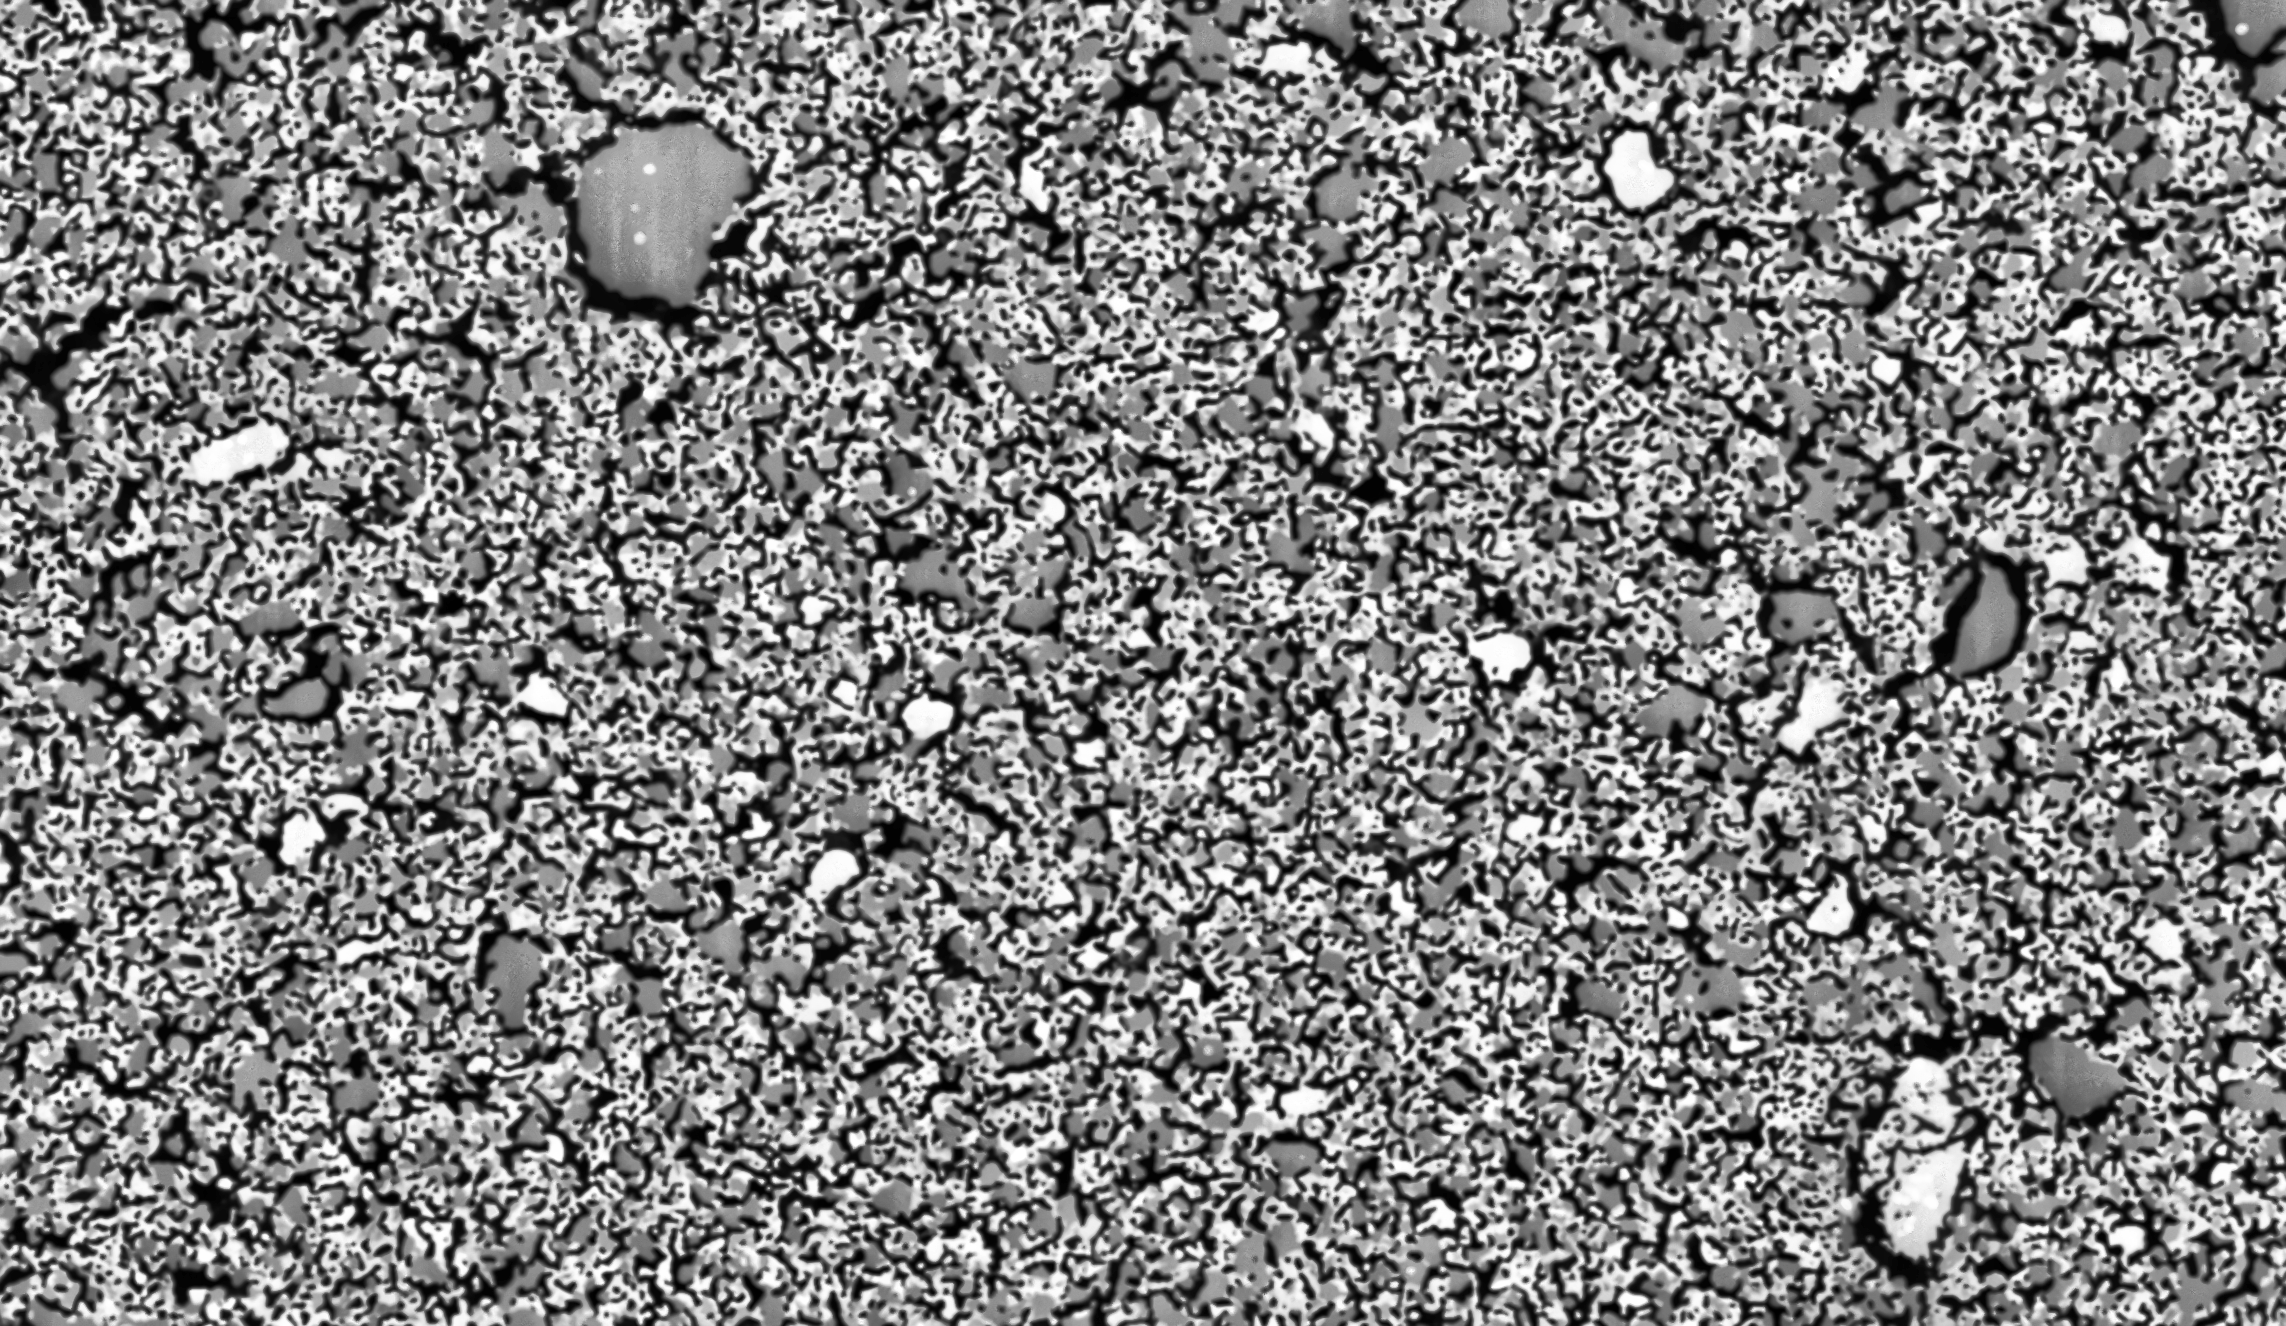

In [22]:
img = frames[101]
img

In [23]:
vol_shape = (len(frames), frames[0].size[1], frames[0].size[0])
print(f"Volume shape: {vol_shape} (Frames, Height, Width)")

Volume shape: (250, 1326, 2286) (Frames, Height, Width)


Batch 0:
Volume shape: torch.Size([4, 1, 32, 128, 128])
Volume min/max: 0.0000/1.0000
Source files: ['/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif']
Volume indices: tensor([0, 0, 0, 0])
Positions: [tensor([ 80,   0, 112,  32]), tensor([896, 960, 384, 960]), tensor([576, 832, 896, 480])]
--------------------------------------------------


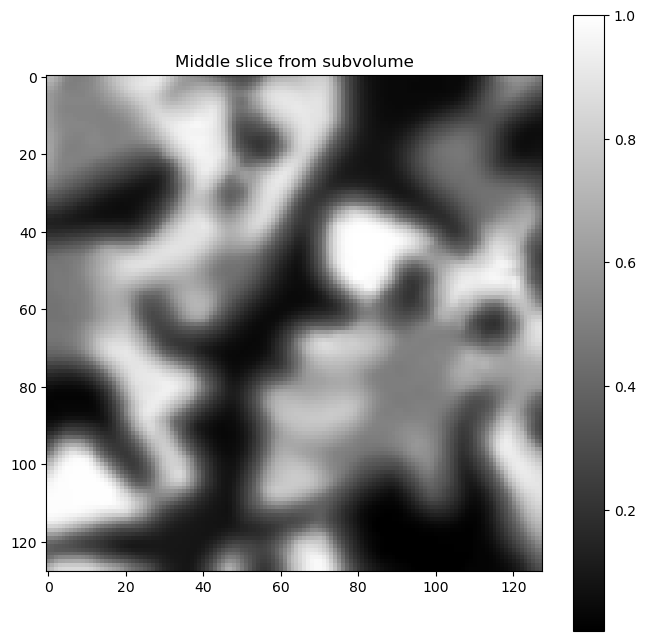

Batch 1:
Volume shape: torch.Size([4, 1, 32, 128, 128])
Volume min/max: 0.0000/1.0000
Source files: ['/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif']
Volume indices: tensor([0, 0, 0, 0])
Positions: [tensor([128,  32,  64,   0]), tensor([ 960, 1088, 1088,  768]), tensor([1792, 1056, 1472,  288])]
--------------------------------------------------
Batch 2:
Volume shape: torch.Size([4, 1, 32, 128, 128])
Volume min/max: 0.0000/1.0000
Source files: ['/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif', '/Users/hai/Documents/Github/WGAN-SOC/datasets/cathode_greyscale/combined_stack.tif'

In [27]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
from utils.dataset import TiffVolumeDataset, NormalizeVolume, ResizeVolume

# Example transformations pipeline
transform = T.Compose([
    NormalizeVolume(),  # Normalize to [0, 1]
    ResizeVolume((32, 128, 128)),  # Resize to target shape
])


dataset = TiffVolumeDataset(
    tiff_paths=[output_path],  # Path to the combined TIFF file
    subvolume_shape=(32, 64, 64),  # Extract 32x64x64 subvolumes
    stride=(16, 32, 32),  # Overlap by 50%
    transform=transform,
    preload=False  # Set to True to load all data into memory
)

# Create DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

# Example of iterating through batches
for batch_idx, batch in enumerate(dataloader):
    volumes = batch['volume']  # shape: (batch_size, channels, depth, height, width)
    
    print(f"Batch {batch_idx}:")
    print(f"Volume shape: {volumes.shape}")
    print(f"Volume min/max: {volumes.min().item():.4f}/{volumes.max().item():.4f}")
    print(f"Source files: {batch['path']}")
    print(f"Volume indices: {batch['volume_idx']}")
    print(f"Positions: {batch['position']}")
    print("-" * 50)
    
    # Visualize middle slice of first volume in batch
    if batch_idx == 0:
        middle_slice = volumes[0, 0, volumes.shape[2]//2].numpy()
        plt.figure(figsize=(8, 8))
        plt.imshow(middle_slice, cmap='gray')
        plt.title(f"Middle slice from subvolume")
        plt.colorbar()
        plt.show()
        
    if batch_idx >= 2:  # Show only first few batches
        break